In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import node2vec
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm.notebook import tqdm
from collections import defaultdict
import itertools
from datetime import date
from geopy.distance import geodesic

In [164]:
df = pq.read_table('Downloads/data_made_restaurants.parquet').to_pandas()

In [165]:
print(f'Initial data size: {df.shape[0]}')

Initial data size: 2780801


In [166]:
# remove customer_id = -10 - as unknown customer
unknown_customer_index = (df.customer_id == -10)
df = df.loc[~unknown_customer_index]
print(f'Removed {sum(unknown_customer_index)} records by unknown customers, data size: {df.shape[0]}')

Removed 21976 records by unknown customers, data size: 2758825


In [167]:
# remove df.product_group_ids is None - not a restaurants, they are food markets
market_index = pd.isnull(df.product_group_ids)
markets = df[market_index]['chain_name'].unique()
print(f'Food markets:\n{markets}\n')
df = df.loc[~market_index]
print(f'Removed {sum(market_index)} records with food markets, data size: {df.shape[0]}')

Food markets:
['Самокат. Продукты' 'Быстроном' 'Верный' 'ВкусВилл' 'Три Плова' 'Merzen'
 'Граф Быстров' 'Бейрут' 'Упитанный Енот' 'Fishka' 'ЕвроСтоловая'
 'Доктор Столетов' 'Маленькая Япония' 'Японо Мама' 'ВкусВиллАйс'
 'Радио Ирландия' 'ФО-БО' 'Matreshka Coffee' 'Баскин Роббинс'
 'Хлебная Корзина' 'Юность' 'Кулинария№1' 'Супераптека' 'Любимчик'
 'Picker App test 1' 'На Шампуре' 'METRO' 'Kimchi' 'BROOKLYN' 'Магнит'
 'Самсон Фарма' 'Озерки' 'Утконос МИНИ' 'Дикси' 'Сырная крошка' 'Мираторг'
 'Brioche' 'TRITON' 'Privet Coffee' 'Лес' 'Пловная' 'Азбука Вкуса' 'Ашан']

Removed 199615 records with food markets, data size: 2559210


In [169]:
df['date'] = pd.to_datetime(df['date'])

In [177]:
pd.set_option('display.max_columns', 100)
df.head()

,Unnamed: 0,customer_id,order_id,user_latitude,user_longitude,date,city_id,chain_id,vendor_id,target,total_value,discount_value,delivery_fee,chain_name,ddk_flag,vendor_latitude,vendor_longitude,online_payment,accepting_cash,min_delivery_value,takeaway_support,citymobil_support,default_product_group_id,product_group_ids,cuisine_ids
0,0,15955880,207845807,55.7815,37.5307,2020-08-01,1,140718,343852,1,575,0,0,Cinnabon,0,55.778137,37.6024,1,0,1000,1,0,30.0,[30],None
1,1,62512097,207855295,55.6472,37.4682,2020-08-01,1,140718,343852,1,1360,0,0,Cinnabon,0,55.778137,37.6024,1,0,1000,1,0,30.0,[30],None
2,2,64977556,207871966,55.8649,37.5014,2020-08-01,1,140718,343852,1,560,0,0,Cinnabon,0,55.778137,37.6024,1,0,1000,1,0,30.0,[30],None
3,3,81281415,207960541,55.8711,37.5105,2020-08-01,1,140718,343852,1,1130,0,0,Cinnabon,0,55.778137,37.6024,1,0,1000,1,0,30.0,[30],None
4,4,72045218,208028305,55.8166,37.5899,2020-08-01,1,140718,343852,1,745,0,0,Cinnabon,0,55.778137,37.6024,1,0,1000,1,0,30.0,[30],None


In [173]:
# there are only positive targets
df.target.mean()

1.0

In [179]:
print(f'# of datapoints: {df.shape}')
print(f'# of unique customer_id: {df.customer_id.nunique()}')
print(f'# of unique chain_id: {df.chain_id.nunique()}')
print(f'# of unique vendor_id: {df.vendor_id.nunique()}')
print(f'# of unique order_id: {df.order_id.nunique()}')

# of datapoints: (2559210, 25)
# of unique customer_id: 1517048
# of unique chain_id: 13977
# of unique vendor_id: 23701
# of unique order_id: 2559210


In [245]:
def plot_sparse(df, col, values=20):
    stats = df[[col]].groupby(col)[col].agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats_sort = stats['count'].value_counts().reset_index()
    stats_sort = stats_sort.sort_values('index')
    plt.figure(figsize=(15,4))
    plt.bar(stats_sort['index'].astype(str).values[0:values], stats_sort['count'].values[0:values])
    plt.title(f'Frequency of {col}')
    plt.xlabel('Number frequency')
    plt.ylabel('Frequency')

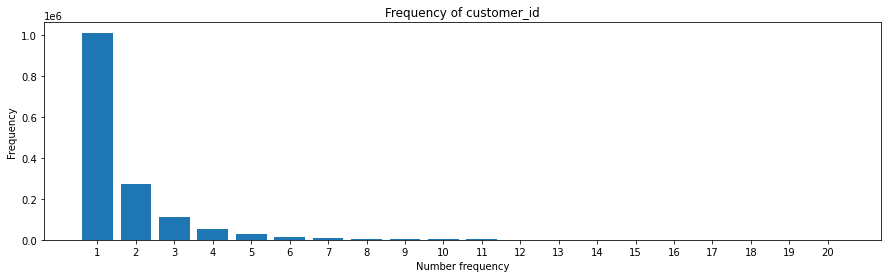

In [246]:
plot_sparse(df, 'customer_id')

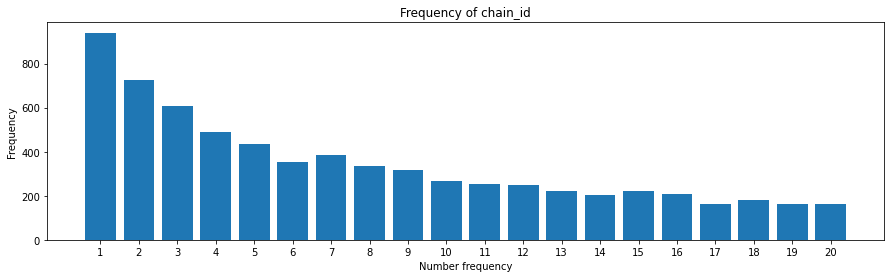

In [247]:
plot_sparse(df, 'chain_id')

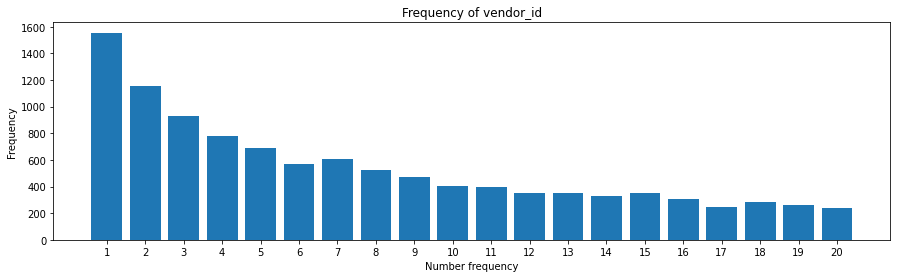

In [248]:
plot_sparse(df, 'vendor_id')

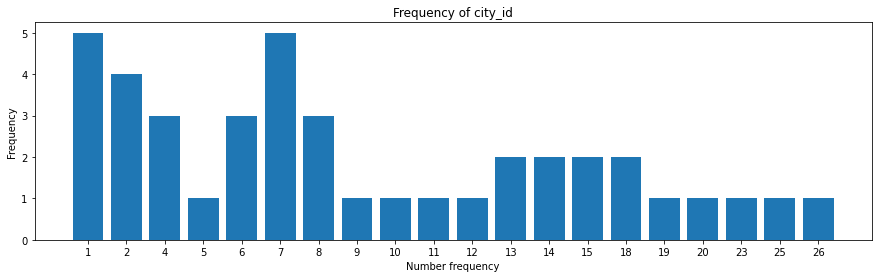

In [249]:
plot_sparse(df, 'city_id')

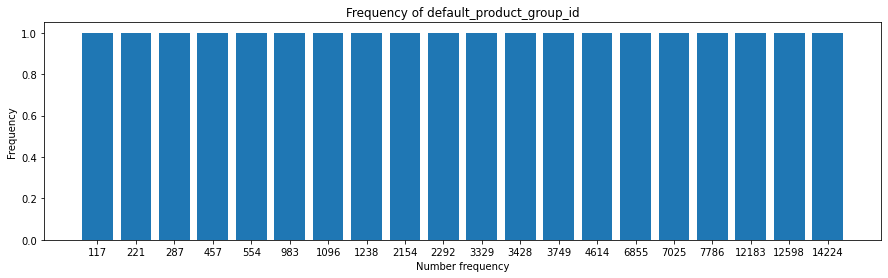

In [250]:
plot_sparse(df, 'default_product_group_id')

In [267]:
def plot_topn(df, col, values=20):
    stats = df[[col]].groupby(col)[col].agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats = stats.sort_values('count', ascending=False)
    plt.figure(figsize=(15,4))
    plt.bar(stats[col].astype(str).values[0:values], stats['count'].values[0:values])
    plt.xticks(rotation='vertical')
    plt.title(f'Top{values} {col} based on frequency')
    plt.xlabel(col)
    plt.ylabel('Frequency')

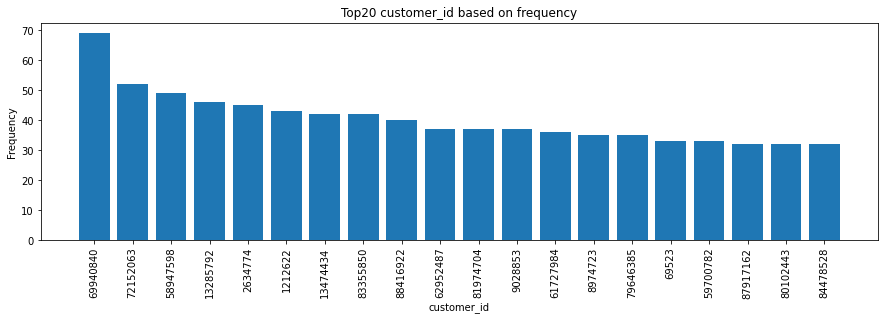

In [268]:
plot_topn(df, 'customer_id')

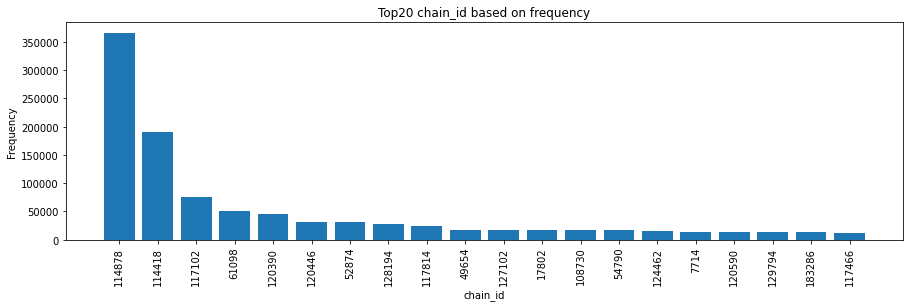

In [218]:
plot_topn(df, 'chain_id')

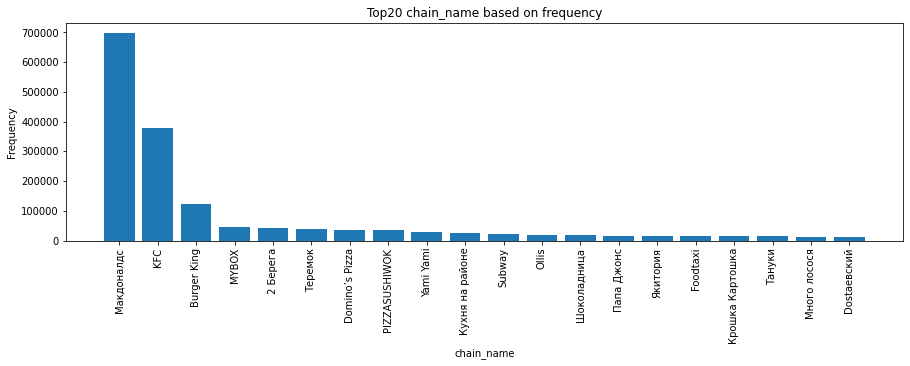

In [219]:
plot_topn(df, 'chain_name')

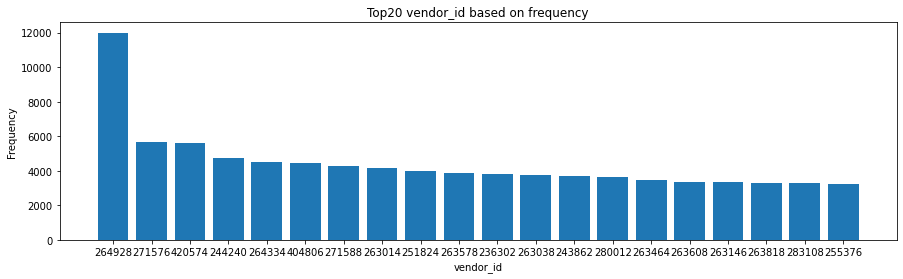

In [214]:
plot_topn(df, 'vendor_id')

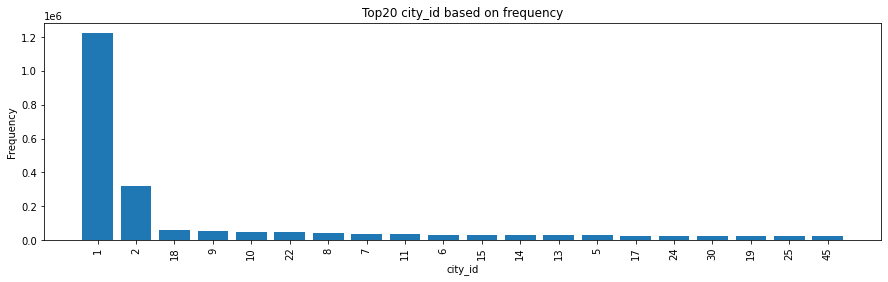

In [220]:
plot_topn(df, 'city_id')

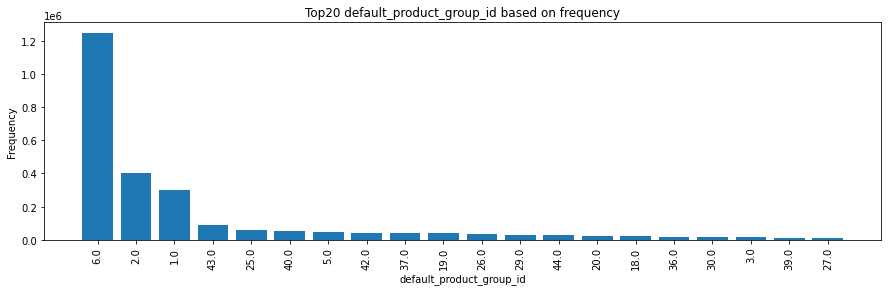

In [221]:
plot_topn(df, 'default_product_group_id')

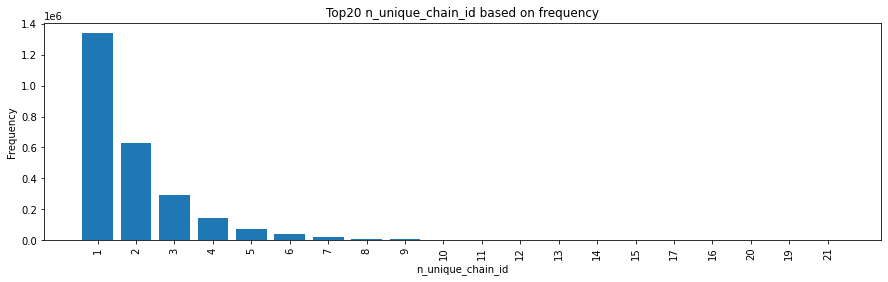

In [271]:
unique_chain_id_per_customer = data=df.groupby('customer_id')['chain_id'].transform('nunique').reset_index()
unique_chain_id_per_customer.columns = ['', 'n_unique_chain_id']
plot_topn(unique_chain_id_per_customer, 'n_unique_chain_id')

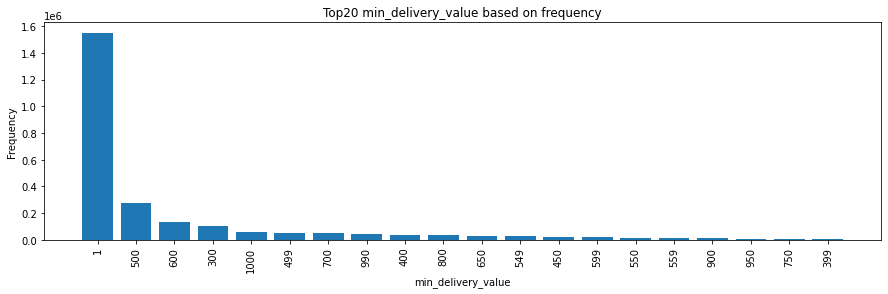

In [327]:
plot_topn(df, 'min_delivery_value')

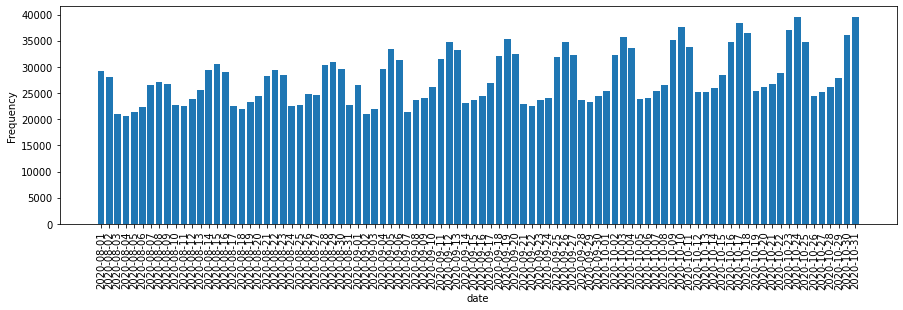

In [241]:
plt.figure(figsize=(15,4))

values = df.date.value_counts()
plt.bar(values.index, values)
plt.xticks(values.index, rotation='vertical')
plt.xlabel('date')
plt.ylabel('Frequency')
_ = plt.show()

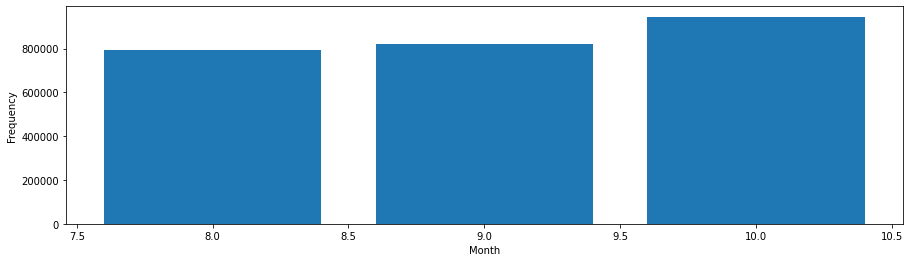

In [239]:
plt.figure(figsize=(15,4))

values = df.date.dt.month.value_counts()
plt.bar(values.index, values)
plt.xlabel('Month')
plt.ylabel('Frequency')
_ = plt.show()

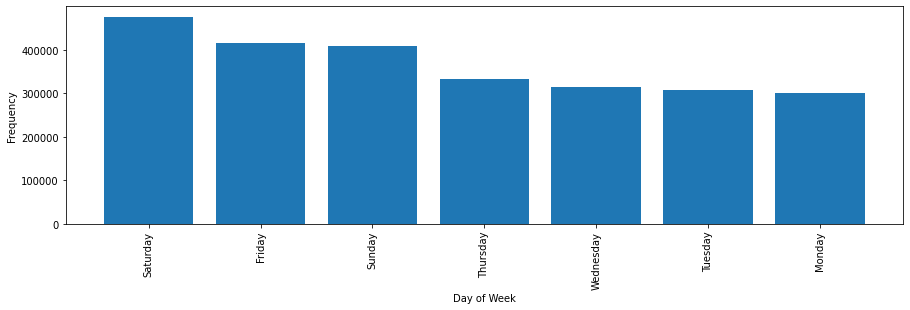

In [240]:
plt.figure(figsize=(15,4))

values = df.date.dt.weekday_name.value_counts()
plt.bar(values.index, values)
plt.xticks(rotation='vertical')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
_ = plt.show()

In [281]:
# No missing data except cuisine_ids 
df.isna().sum()

Unnamed: 0                        0
customer_id                       0
order_id                          0
user_latitude                     0
user_longitude                    0
date                              0
city_id                           0
chain_id                          0
vendor_id                         0
target                            0
total_value                       0
discount_value                    0
delivery_fee                      0
chain_name                        0
ddk_flag                          0
vendor_latitude                   0
vendor_longitude                  0
online_payment                    0
accepting_cash                    0
min_delivery_value                0
takeaway_support                  0
citymobil_support                 0
default_product_group_id          0
product_group_ids                 0
cuisine_ids                 1868452
dtype: int64

In [305]:
def dist(row):
    user_point = (row['user_latitude'], row['user_longitude'])
    vendor_point = (row['vendor_latitude'], row['vendor_longitude'])
    return geodesic(user_point, vendor_point).kilometers

In [307]:
df['dist'] = df.apply(dist, axis=1)

In [330]:
df[['dist', 'total_value', 'discount_value', 'min_delivery_value']].agg(['mean', 'median'])

,dist,total_value,discount_value,min_delivery_value
mean,1.899439,894.11675,91.411274,232.855099
median,1.332269,780.00000,0.000000,1.000000
